In [1]:
directory = 'TRACES_DATA_CONVERTED';
load('TRACES_DATA_CONVERTED\keys.mat')
load('TRACES_DATA_CONVERTED\pti.mat')
load('TRACES_DATA_CONVERTED\cto.mat')
load('TRACES_DATA_CONVERTED\traces.mat')

disp('Tailles des matrices :')
disp(['keys : ' num2str(size(keys))])
disp(['pti : ' num2str(size(pti))])
disp(['cto : ' num2str(size(cto))])
disp(['traces : ' num2str(size(traces))])

Tailles des matrices :
keys : 20000     16
pti : 20000     16
cto : 20000     16
traces : 20000   4000



# Affichage de la moyenne des traces
On trace la moyenne des traces sur un graphique. On voit que l'on obtient 12 pics. Or, on sait que l'AES-128 est sur 10 tours. 
Cette différence vient d'une mauvaise implémentation matérielle. C'est notamment pour cela que l'on attaque par le bas de l'algorithme.
=> On attaque sur le 10e round.

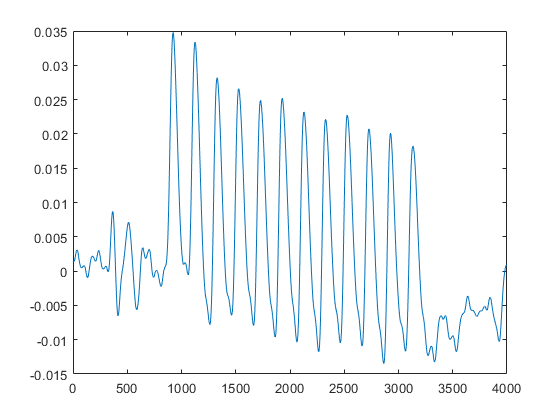

In [2]:
traces_mean = mean(traces);
figure
plot(traces_mean)


# Objectif
On cherche à inverser les fonctions de chiffrement. 
Notamment, on cherche à inverser la S_Box.

Etape 1 : on cherche les hypothèses sur les clés => $w_{10}$ \
Etape 2 : on crée toutes les hypothèses pour les sous-clés => $Z$ de dimension $[N_t \times 256]$ \
Etape 3 : on remonte les boîtes de l'algo (ShiftRow et SBox) \
Etape 4 : on fait une corrélation entre les traces et les hypothèses

In [2]:
keys4x4 = reshape(keys(1, :), [4 4])
all_w = keysched2(uint32(keys4x4));

all_w(:, :, 1)
w10 = all_w(:, :, 11) % point d'arrivée. Objectif de l'algorithme



keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


ans =

  4x4 uint32 matrix

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


w10 =

  4x4 uint32 matrix

    60    64    77    37
    71   214    56   251
    64   128     0   120
     1   146   185   176




In [3]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);

SBox = [99, 124, 119, 123, 242, 107, 111, 197, 48, 1, 103, 43, 254, 215, 171, 118, 202, 130, 201, 125, 250, 89, 71, 240, 173, 212, 162, 175, 156, 164, 114, 192, 183, 253, 147, 38, 54, 63, 247, 204, 52, 165, 229, 241, 113, 216, 49, 21, 4, 199, 35, 195, 24, 150, 5, 154, 7, 18, 128, 226, 235, 39, 178, 117, 9, 131, 44, 26, 27, 110, 90, 160, 82, 59, 214, 179, 41, 227, 47, 132, 83, 209, 0, 237, 32, 252, 177, 91, 106, 203, 190, 57, 74, 76, 88, 207, 208, 239, 170, 251, 67, 77, 51, 133, 69, 249, 2, 127, 80, 60, 159, 168, 81, 163, 64, 143, 146, 157, 56, 245, 188, 182, 218, 33, 16, 255, 243, 210, 205, 12, 19, 236, 95, 151, 68, 23, 196, 167, 126, 61, 100, 93, 25, 115, 96, 129, 79, 220, 34, 42, 144, 136, 70, 238, 184, 20, 222, 94, 11, 219, 224, 50, 58, 10, 73, 6, 36, 92, 194, 211, 172, 98, 145, 149, 228, 121, 231, 200, 55, 109, 141, 213, 78, 169, 108, 86, 244, 234, 101, 122, 174, 8, 186, 120, 37, 46, 28, 166, 180, 198, 232, 221, 116, 31, 75, 189, 139, 138, 112, 62, 181, 102, 72, 3, 246, 14, 97, 53, 87, 185, 134, 193, 29, 158, 225, 248, 152, 17, 105, 217, 142, 148, 155, 30, 135, 233, 206, 85, 40, 223, 140, 161, 137, 13, 191, 230, 66, 104, 65, 153, 45, 15, 176, 84, 187, 22];

invSBox(SBox(1:256) + 1) = 0:255;
size(SBox)
size(invSBox)

Weight_Hamming_vect = [0 1 1 2 1 2 2 3 1 2 2 3 2 3 3 4 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 1 2 2 3 2 3 3 4 2 3 3 4 3 4 4 5 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 2 3 3 4 3 4 4 5 3 4 4 5 4 5 5 6 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 3 4 4 5 4 5 5 6 4 5 5 6 5 6 6 7 4 5 5 6 5 6 6 7 5 6 6 7 6 7 7 8];



ans =

     1   256


ans =

     1   256




# A faire
- Inversion du shiftrow (faire des tests ou à la main)
- Calcul des Zi (Z3 notamment)
- Comparaison de la corrélation entre les traces et les hypothèses (Zi) => on cherche à trouver le max de corrélation


Poids Hamming déjà fourni => table de correspondance entre vals et poids hamming
SBox-1 déjà fourni aussi => table de correspondance entre vals et vals inversées

In [4]:
shiftrow = [1, 6, 11, 16, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12];
shiftrow = reshape(shiftrow, [4 4]);
% size(shiftrow)
shiftrow
keys4x4_shifted = keys4x4(shiftrow);
keys4x4_shifted
% shiftrow = shiftrow(shiftrow)
% shiftrow = shiftrow(shiftrow)
% shiftrow = shiftrow(shiftrow)

for i = 1:4

    for j = 1:4
        inv_shiftrow(i, j) = mod(shiftrow(i, j) + 8 * mod(i - 1, 2), 16);

        if inv_shiftrow(i, j) == 0
            inv_shiftrow(i, j) = 16;
        end

    end

end

inv_shiftrow
keys4x4_shifted(inv_shiftrow)
% keys4x4_shifted
keys4x4
% size(inv(shiftrow))
% size(SBox)
% size(invSBox)



shiftrow =

     1     5     9    13
     6    10    14     2
    11    15     3     7
    16     4     8    12


keys4x4_shifted =

    76   181   144   132
   201    87    25   140
   236    58   223     6
   103    35   247   113


inv_shiftrow =

     1     5     9    13
    14     2     6    10
    11    15     3     7
     8    12    16     4


ans =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103


keys4x4 =

    76   181   144   132
   140   201    87    25
   223     6   236    58
    35   247   113   103




Penser à itérer les calculs que l'on fait sur 1 itérations pour les 16 valeurs que l'on a. (dans cto et pti)


In [5]:
hypothese = uint8(ones(size(cto, 1), 1) * (0:255));
% size(hypothese)
cto_extended = uint8(single(cto(:, 1)) * ones(1, 256));
% size(cto_extended)

Z1 = bitxor(cto_extended, hypothese);
Z1(1:10, 1:10)
size(Z1)

% On inverse le vecteur shiftrow
% Z2 = Z1(inv_shiftrow)
% Z2(1:10, 1:10)
% size(Z2)
% Z2 = shiftrow(Z1);


ans =

  10x10 uint8 matrix

    85    84    87    86    81    80    83    82    93    92
   110   111   108   109   106   107   104   105   102   103
    30    31    28    29    26    27    24    25    22    23
   137   136   139   138   141   140   143   142   129   128
   239   238   237   236   235   234   233   232   231   230
   121   120   123   122   125   124   127   126   113   112
   155   154   153   152   159   158   157   156   147   146
   208   209   210   211   212   213   214   215   216   217
    15    14    13    12    11    10     9     8     7     6
   244   245   246   247   240   241   242   243   252   253


ans =

       20000         256




In [6]:
size(Z1)
size(Weight_Hamming_vect)
pt_attack1=Z1(Weight_Hamming_vect+1);
pt2=Weight_Hamming_vect(Z1+1);
% size(pt_attack1)
sum(pt_attack1);
% pt2=sum(pt2);


ans =

       20000         256


ans =

     1   256




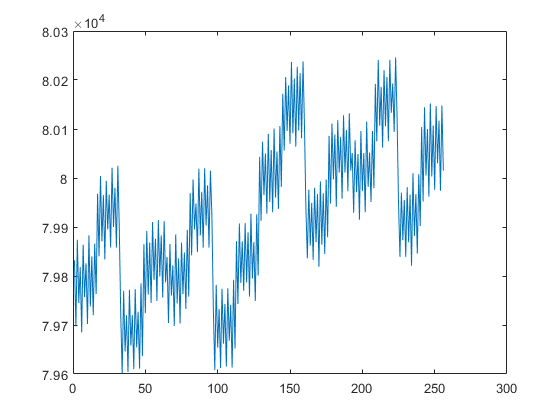

In [23]:
pt2_affichage = sum(pt2);
plot(pt2_affichage)

In [7]:
Z3=invSBox(Z1+1);
size(Z3)
pt3=Weight_Hamming_vect(Z3+1);
size(pt3)


ans =

       20000         256


ans =

       20000         256





ans =

     1   256




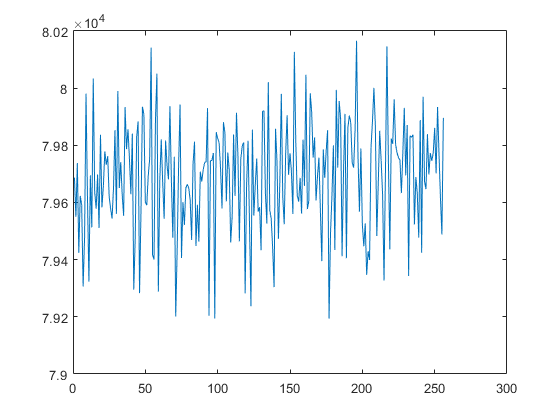

In [9]:
pt3_affichage = sum(pt3);
size(pt3_affichage)
plot(pt3_affichage)
% plot(pt3)


ans =

         256        4000




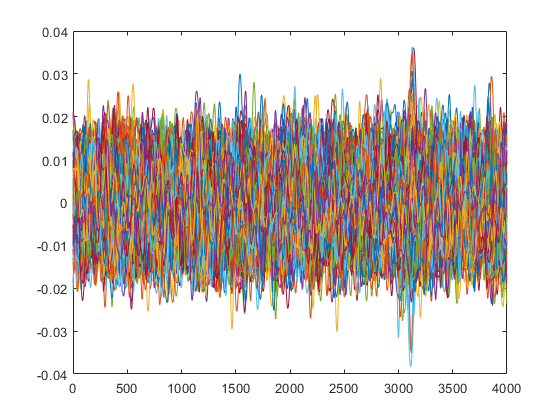

In [13]:
correlation = corr(single(pt3), traces);
% corr(single(pt3), traces);
size(correlation)
plot(0:size(correlation, 2) - 1, correlation(1:256, :))

In [14]:
[RK,IK] = sort(max(abs(correlation),[],2),'descend');
sprintf('%s %d','meilleur candiat : k =',IK(1)-1)
best_candidate=IK(1);


ans =

    'meilleur candiat : k = 166'




In [ ]:

size(pti)
size(cto)
pti(1, :)

cto(1, :)

In [26]:
matrix = ones(size(cto,1),1) * (0:255);
size(matrix)

% matrix2= single(cto) * ones(1, 16);
% size(matrix2)


ans =

       20000         256


ans =

  20000x16 single matrix

    85    75    64   125    54    52    21   108     8    26   190    49   117    46   189     2
   110    98   217    82   229   198   203   253   213   182    48    38   178   109   147   107
    30    28   102   191   130    43   237   253   250    57   113   217    63    69   253    39
   137    69   137   118   155   184   201   219    32     3   222    89   156   148   203   207
   239   193   181    48   248   159   114    37    74   138   213    17   190   109    22   187
   121   126     5   242    42   184   178   182   173     4   223    33     2    10   110   239
   155   190   204   185   181   108   178   167   122     2   160    31    55   110   113   183
   208   184   103   127   140   124    37    85    39   123   173    36   134   130    16   196
    15   172    48   171   218   210   218   216    70    62    76    77   174   229    30    18
   244   184   164    65     6    52   183   230    99    4